In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from utilities import *
from constants import *
from preprocess import *
from graphing import *


[nltk_data] Downloading package wordnet to
[nltk_data]     /yw_data/robert_gold/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
survey_results = preprocess(DATA)

These files and their respective papers can all be downloaded from 
    http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

 If you use this list, please cite the following paper:

   Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
       Proceedings of the ACM SIGKDD International Conference on Knowledge 
       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
       Washington, USA, 

Notes: 
    1. The appearance of an opinion word in a sentence does not necessarily  
       mean that the sentence expresses a positive or negative opinion. 
       See the paper below:
       Bing Liu. "Sentiment Analysis and Subjectivity." An chapter in 
          Handbook of Natural Language Processing, Second Edition, 
         (editors: N. Indurkhya and F. J. Damerau), 2010.
    2. You will notice many misspelled words in the list. They are not 
       mistakes. They are included as these misspelled words appear 
       frequently in social media content.
       
### TODO: Remove mispelled words because they are caught by spellcheck?

In [3]:
NEGATIVE_WORDS = list(map(str.strip, list(open(NEGATIVE_WORDS_FILE, 'r'))))
POSITIVE_WORDS = list(map(str.strip, list(open(POSITIVE_WORDS_FILE, 'r'))))
assert '' not in NEGATIVE_WORDS and '' not in POSITIVE_WORDS

for word in NEGATIVE_WORDS:
    assert '\n' not in word
    if word in POSITIVE_WORDS: print(word)
for word in POSITIVE_WORDS:
    assert '\n' not in word
    if word in NEGATIVE_WORDS: print(word)

envious
enviously
enviousness
envious
enviously
enviousness


In [4]:
POSITIVE_EMOTICONS = [":)", ":D", ":-)", ":-D", ";D", ";-D"]
NEGATIVE_EMOTICONS = [":(", ":'(", ":-(", ";(", ">:(", "=(", ";-(", ">:-(", ">.<"]
NEGATION_WORDS = ["not", "yet", "never", "nowhere", "nobody", "none", "nothing", "hardly", "scarcely"]
POSITIVE = 1
NEGATIVE = -1
NEUTRAL = 0
DEFAULT_NEGATION_WINDOW = 5

def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max - to_min) * (unscaled - from_min) / (from_max - from_min) + to_min

def get_sentiment(words):
    """ 
    The words should be filtered, tokenized, etc. before calling this function.
    """

    orientation = NEUTRAL
    negation_flag = False
    negation_window = DEFAULT_NEGATION_WINDOW
    n_tokens = 0
    
    for word in words:
        if word in POSITIVE_EMOTICONS:
            orientation = POSITIVE
            n_tokens += 1
            break
        elif word in NEGATIVE_EMOTICONS:
            orientation = NEUTRAL
            n_tokens += 1
            break
        
        if word in NEGATION_WORDS:
            #n_tokens += 1
            negation_flag = True
            negation_window = DEFAULT_NEGATION_WINDOW
            #orientation -= 1
        
        if word in POSITIVE_WORDS:
            n_tokens += 1
            orientation += -1 if negation_flag else 1
            print(word, orientation)
        elif word in NEGATIVE_WORDS:
            n_tokens += 1
            orientation += 1 if negation_flag else -1
            print(word, orientation)
        
        negation_window -= 1
        if negation_window == 0:
            negation_flag = False
    
    # TODO: IS THIS RIGHT???
    orientation /= max(n_tokens, 1)
    #orientation = scale_number(orientation, 0, 1, -1, 1)
    
    return orientation

In [5]:
sentence = 'it was not good'
normalized = normalize(sentence)
print(normalized)
print(get_sentiment(normalized.split()))

it be not good
good -1
-1.0


**NOTES:** classifies "problem" as negative even though its a synonym for "solution"

In [6]:
print(get_sentiment(['I', 'am', 'having', 'a', 'lot', 'of', 'trouble', 'this', 'problem', 'is', 'way', 'too', 'difficult']))
print(get_sentiment(['I', 'do', 'not', 'know', 'how', 'to', 'do', 'this', 'problem', 'but', 'i', 'love', 'this', 'problem']))
print(get_sentiment(['I', 'need', 'help'])) # This should be negative
print(get_sentiment("I love this question, and I love coding.".split()))
print(get_sentiment("I love this question, but I hate coding.".split()))


trouble -1
problem -2
difficult -3
-1.0
problem -1
love 0
problem -1
-0.3333333333333333
0.0
love 1
love 2
1.0
love 1
hate 0
0.0


In [7]:
def plot_sentiments(data):
    for problem, results in data.items():
        results['Sentiment'].plot(kind='hist')
        plt.suptitle(problem)
        plt.show()

In [11]:
for problem in survey_results:
    results = survey_results[problem]
    results['Words'] = results['Answer'].str.split().str.len()
    survey_results[problem] = results[results['Words'] > 0]
    assert 0 not in survey_results[problem]['Words'].unique()

for results in survey_results.values():
    assert 0 not in results['Words'].unique()

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def get_vader_sentiment(sentence):
    return analyser.polarity_scores(sentence)['compound']


for problem, results in survey_results.items():
    results['Vader'] = results['Answer'].apply(lambda x: get_vader_sentiment(x))


In [13]:
def get_average_sentiment(data, key = 'Sentiment'):
    return np.mean(np.array(data[key]))

def get_student_Q1_Q2_means(student_results, key= 'Sentiment'):
    student_Q1_Q2_means = []
    for student, results in student_results.items():
        if not results[results['Question']==Q1].empty and not results[results['Question']==Q2].empty:
            Q1_mean = np.mean(np.array(results[results['Question']==Q1][key]))
            Q2_mean = np.mean(np.array(results[results['Question']==Q2][key]))
            student_Q1_Q2_means.append([Q1_mean, Q2_mean])
    
    return np.array(student_Q1_Q2_means)
merged_results = merge_problem_data(survey_results)

student_results = get_student_results(merged_results)

    


In [17]:
def partition(data, key, endpoints, include_extremes = True):
    partitions = {}
    for k in range(len(endpoints)-1):
        dict_key = "[{0},{1})".format(endpoints[k], endpoints[k+1])
        partitions[dict_key] = data[(data[key] >= endpoints[k]) & (data[key]<endpoints[k+1])]
    if include_extremes:
        partitions["[,{0})".format(endpoints[0])] = data[data[key] < endpoints[0]]
        partitions["[{0},)".format(endpoints[len(endpoints)-1])] = data[data[key] >= endpoints[len(endpoints)-1]]
    return partitions



In [18]:
part = partition(merged_results[merged_results['Question']==Q2], 'Vader', [-1.1, -0.2, 0.2, 1.1], include_extremes=False)
for interval in part.keys():
    part[interval] = partition(part[interval], 'Sentiment', [-0.1, 0.4, 0.6, 1.1], include_extremes=False)
    part[interval] = [len(p) for i, p in part[interval].items()]
arr = np.array([a for a in part.values()])
arr

array([[105,   1,   9],
       [981,   1, 123],
       [231,   4, 188]])

In [19]:
merged_results = get_manual_tags(merged_results, 'manual_tags_Q1.csv')
merged_results = get_manual_tags(merged_results, 'manual_tags_Q2.csv')
labeled_results = merged_results[~(merged_results['Manual Tag'] == 'no tag')]
labeled_results.shape

(701, 19)

In [20]:
def get_categorical_tag_from_sentiment(sentiment, neutral_threshold = 0.2):
    if sentiment >= neutral_threshold:
        return 'positive'
    elif sentiment <= (-1) * neutral_threshold:
        return 'negative'
    return 'neutral'
def get_categorical_array(data, key = 'Sentiment', neutral_threshold = 0.2):
    if key == 'Sentiment':
        return data[key].apply(lambda x: get_categorical_tag_from_sentiment(x, neutral_threshold = neutral_threshold))
    return data[key].apply(lambda x: get_categorical_tag_from_sentiment(x, neutral_threshold = neutral_threshold))

cat_array = get_categorical_array(labeled_results)
lst = list(cat_array)
print(len([l for l in lst if l =='positive']))
print(len([l for l in lst if l =='neutral']))
print(len([l for l in lst if l =='negative']))

150
445
106


In [21]:
def normalized(a, axis=-1, order=2):
    l1 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l1[l1==0] = 1
    return a / np.expand_dims(l1, axis)

def categorical_heatmap(y, y_pred, title = '', normalize = False):
    cf_matrix = confusion_matrix(y, y_pred, labels = CLASS_NAMES)
    if normalize:
        cf_matrix = normalized(cf_matrix, axis = 1, order = 1)
        sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=CLASS_NAMES, yticklabels = CLASS_NAMES, square = True, vmin = 0, vmax = 1)
    else:
        sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=CLASS_NAMES, yticklabels = CLASS_NAMES, square = True, fmt = 'd')
    plt.yticks(rotation=0, size = 14)
    plt.xticks(size = 14)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.title(title, fontsize = 16)
    

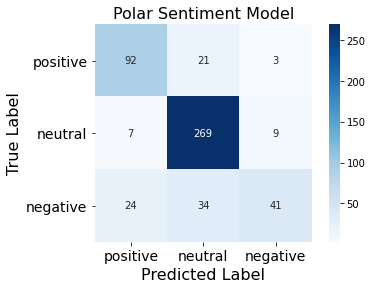

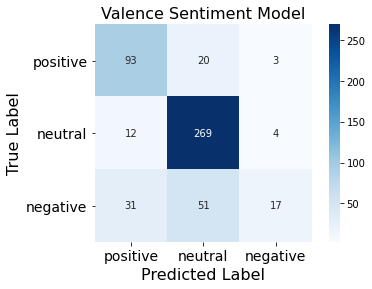

In [22]:
q1_labeled_results = labeled_results[labeled_results['Question'] == Q1]
categorical_heatmap(q1_labeled_results['Categorical Tag'], 
                    get_categorical_array(q1_labeled_results, neutral_threshold = 0.3), 
                    title = 'Polar Sentiment Model', 
                    normalize = False)
plt.show()
categorical_heatmap(q1_labeled_results['Categorical Tag'], 
                    get_categorical_array(q1_labeled_results, neutral_threshold = 0.3, key = 'Vader'), 
                    title = 'Valence Sentiment Model', 
                    normalize = False)

In [23]:
from supervised_sentiment_analysis import *
from sklearn.metrics import cohen_kappa_score
correct_labels = list(q1_labeled_results['Categorical Tag'])
vader_labels = list(get_categorical_array(q1_labeled_results, neutral_threshold = 0.3, key = 'Vader'))
custom_labels = list(get_categorical_array(q1_labeled_results, neutral_threshold = 0.3, key = 'Sentiment'))
print(cohen_kappa_score(correct_labels, vader_labels))
print(cohen_kappa_score(correct_labels, custom_labels))

0.5516791653081186
0.6453002280212821


In [24]:
macro_F(confusion_matrix(correct_labels, vader_labels, labels = CLASS_NAMES))


0.6251060007742933

In [25]:
macro_F(confusion_matrix(correct_labels, custom_labels, labels = CLASS_NAMES))

0.7309211987791823